# **Assignment 2**, **dataset 3**


# Problem statement



### Loading the dataset

The PlantVillage dataset contains 54,304 images. The images span 14 crop species: Apple, Blueberry, Cherry, Corn, Grape, Orange, Peach, Bell Pepper, Potato, Raspberry, Soybean, Squash, Strawberry, Tomato. In containes images of 17 fungal diseases, 4 bacterial diseases, 2 mold (oomycete) diseases, 2 viral disease, and 1 disease caused by a mite. 12 crop species also have images of healthy leaves that are not visibly affected by a disease.

https://arxiv.org/pdf/1511.08060

https://github.com/gabrieldgf4/PlantVillage-Dataset

For this assignment, you will make a model that predicts whether a bell pepper leaf comes from a healthy or unhealthy plant (binary classification). The healthy bell pepper leaf images are in the `Pepper,_bell___healthy` folder, while unhealthy cherry leaf images are in `Pepper,_bell___Bacterial_spot`. You are allowed to use a pretrained model that you transfer to this problem, if you whish so. Keep in mind that the dataset is somewhat uneven between the classes. Make sure to apply a technique to mitigate for that.

In [1]:
# Download the dataset
!git clone https://github.com/gabrieldgf4/PlantVillage-Dataset.git

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 54511, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 54511 (delta 36), reused 0 (delta 0), pack-reused 54403 (from 1)
Receiving objects: 100% (54511/54511), 806.27 MiB | 25.88 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Updating files: 100% (54306/54306), done.


## **Exploratory Data Analysis**

The student will have to make a written analysis of the data being loaded (depending on the dataset that was assigned to them). They should apply methods of inspecting the data and make some exploratory data analysis

In [2]:
import os
DIR = "PlantVillage-Dataset"
#os.listdir('PlantVillage-Dataset') # We are only interested in the healthy and unhealthy bell pepper images
healthy_path = os.path.join(DIR, "Pepper,_bell___healthy")
unhealthy_path = os.path.join(DIR, "Pepper,_bell___Bacterial_spot")

First of all, we check our data distribution. We can see that we have more positive (healthy) than negative (unhealthy) examples; our dataset is thus imbalanced.

In [3]:
healthy_images = os.listdir(healthy_path)
unhealthy_images = os.listdir(unhealthy_path)
print("Healthy bell pepper images:", len(healthy_images))
print("Unhealthy bell pepper images:", len(unhealthy_images))
print("Total data set size:", len(healthy_images)+len(unhealthy_images))

Healthy bell pepper images: 1476
Unhealthy bell pepper images: 997
Total data set size: 2473


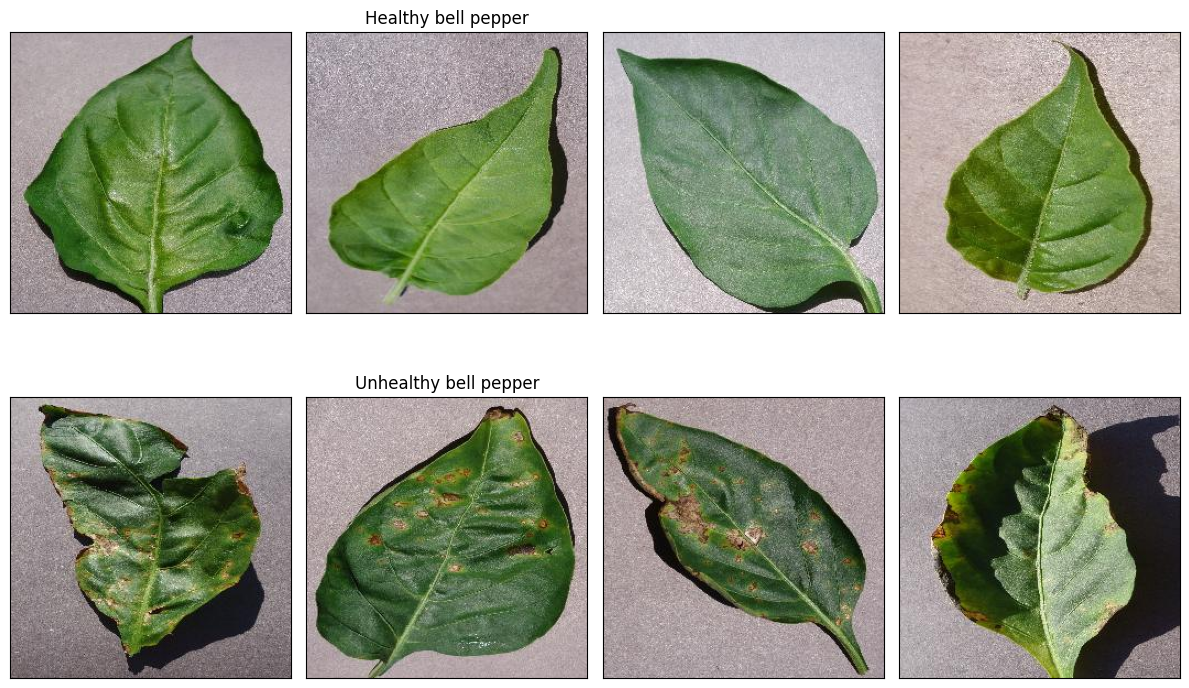

In [4]:
# inspect some examples for healthy and unhealthy bell peppers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

healthy_images_sample = random.sample(healthy_images, 4)
unhealthy_images_sample = random.sample(unhealthy_images, 4)

plt.figure(figsize=(12, 8)) # code modified after Computer_vision_exercise_solutions.ipynb

for i, file_name in enumerate(healthy_images_sample):
  #print(file_name) # we have JPG images
  image = mpimg.imread(os.path.join(healthy_path,file_name))
  #print(image.shape) # (256, 256, 3) --> 256*256 pixels, colour images
  ax = plt.subplot(2, 4, i+1)
  plt.imshow(image)
  plt.axis('on')
  plt.xticks([])
  plt.yticks([])
  if i ==1:
    plt.title("Healthy bell pepper")


for i, file_name in enumerate(unhealthy_images_sample):
  image = mpimg.imread(os.path.join(unhealthy_path,file_name))
  ax = plt.subplot(2, 4, i+5)
  plt.imshow(image)
  plt.axis('on')
  plt.xticks([])
  plt.yticks([])
  if i ==1:
    plt.title("Unhealthy bell pepper")

plt.tight_layout()
plt.show()

## **Data Preprocessing**:

If applicable, the student will create new features from existing data to improve model performance and/or select the most relevant features for the model.

First, we have to create a Dataset from the images including their label (0 or 1 since we are dealing with a binary classification task here). In the getitem()method we then apply the transformations (here resizing to a size our resnet model can work with and a conversion to a tensor).

In [6]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image
import numpy as np


# cf. https://github.com/heraclex12/R-BERT-Relation-Classification/blob/master/BERT_for_Relation_Classification.ipynb, assessed Aug 6, 2025
def set_seed(seed):
    """Sets a random seed."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# code modified from: https://docs.pytorch.org/tutorials/beginner/data_loading_tutorial.html, assessed Aug 2, 2025 and https://medium.com/bivek-adhikari/creating-custom-datasets-and-dataloaders-with-pytorch-7e9d2f06b660.

# define a transform

transform = transforms.Compose([
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # data preprocessing for ResNet18 after https://pytorch.org/hub/pytorch_vision_resnet/
])

transform_augmented = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15), # rotate by 15 degrees
    transforms.RandomVerticalFlip(), # random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

# create labels and merge images together
image_paths = []
labels = []

for fname in os.listdir(healthy_path):
    image_paths.append(os.path.join(healthy_path, fname))
    labels.append(1) # label 1 for healthy bell pepper

for fname in os.listdir(unhealthy_path):
    image_paths.append(os.path.join(unhealthy_path, fname))
    labels.append(0) # label 0 for unhealthy bell pepper


class BellPepperDataset(Dataset):
    """BellPepper Dataset."""

    def __init__(self, image_paths, labels, transform=None, transform_augmented=None):
        """
        Arguments:
            image_paths (list): List of image paths.
            labels (list): List of labels.
            transform (callable, optional): Optional transform to be applied on a sample. For the normal data set, we just resize and convert image to Tensor.
            transform_augmented (callable, optional): Optional transform to be applied on a sample of images to be augmented. Involves random rotation, random vertical flip and colorjitter.
        """
        self.transform = transform
        self.transform_augmented = transform_augmented
        self.image_paths = image_paths
        self.labels = labels
        self.augmented_images = []
        self.augmented_labels = []

    def oversample_minority_class_by_augmenting(self):
      majority_count = self.labels.count(1) # we know that positive is the majority class
      minority_count = self.labels.count(0)
      needed = majority_count - minority_count

      print(f"Augmenting and oversampling dataset by {needed} negatives examples.")

      negative_indices = [i for i, label in enumerate(self.labels) if label == 0]

      for i in range(needed):
        idx = random.choice(negative_indices) # take a random negative image path
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform_augmented:
            image = self.transform_augmented(image)

        self.augmented_images.append(image)
        self.augmented_labels.append(0)


    def __len__(self):
        return len(self.image_paths) + len(self.augmented_images)

    def __getitem__(self, idx):
        if idx < len(self.image_paths):
          image_path = self.image_paths[idx]
          image = Image.open(image_path).convert("RGB")
          label = self.labels[idx]
          if self.transform:
            image = self.transform(image)
        else: # then we are dealing with a transformed image
          image = self.augmented_images[idx - len(self.image_paths)]
          label = self.augmented_labels[idx - len(self.image_paths)]

        return image, label


(tensor([[[0.6157, 0.6392, 0.6627,  ..., 0.7765, 0.7176, 0.5451],
         [0.6314, 0.6510, 0.6627,  ..., 0.6549, 0.5647, 0.6941],
         [0.6824, 0.6824, 0.6745,  ..., 0.6941, 0.6706, 0.6275],
         ...,
         [0.6824, 0.6588, 0.6314,  ..., 0.7294, 0.7412, 0.7608],
         [0.6471, 0.6118, 0.6078,  ..., 0.7333, 0.7451, 0.7686],
         [0.6784, 0.5373, 0.6353,  ..., 0.7451, 0.7608, 0.7843]],

        [[0.5686, 0.5922, 0.6157,  ..., 0.7333, 0.6745, 0.5020],
         [0.5843, 0.6039, 0.6157,  ..., 0.6118, 0.5216, 0.6510],
         [0.6353, 0.6353, 0.6275,  ..., 0.6510, 0.6275, 0.5843],
         ...,
         [0.6314, 0.6078, 0.5804,  ..., 0.7059, 0.7176, 0.7373],
         [0.5961, 0.5608, 0.5569,  ..., 0.7098, 0.7216, 0.7451],
         [0.6275, 0.4863, 0.5843,  ..., 0.7216, 0.7373, 0.7608]],

        [[0.5765, 0.6000, 0.6235,  ..., 0.7490, 0.6902, 0.5176],
         [0.5922, 0.6118, 0.6235,  ..., 0.6275, 0.5373, 0.6667],
         [0.6431, 0.6431, 0.6353,  ..., 0.6667, 0.6431, 0

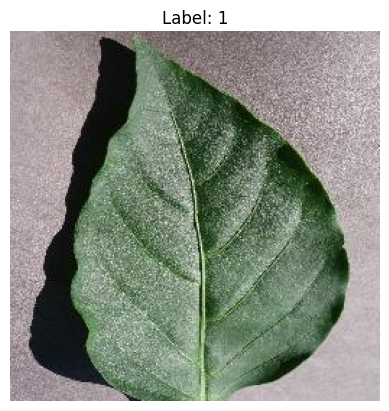

In [17]:
dataset = BellPepperDataset(image_paths, labels, transform, transform_augmented) # sanity check
print(dataset[0])
import torchvision.transforms.functional as TF

image, label = dataset[0]
plt.imshow(TF.to_pil_image(image))
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

## **Data Transformation**

The student should prepare the data for the training. Augmenting, splitting, and otherwise transforming should be done here.

#### Note that data augmentation is performed under Results in order to compare performance for a model trained on balanced and augmented data and imbalanced data.

In [63]:
from sklearn.model_selection import train_test_split

# split data set paths into train, val, test (80-10-10 split)
paths_train, paths_temp, labels_train, labels_temp = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

paths_eval, paths_test, labels_eval, labels_test = train_test_split(paths_temp, labels_temp, test_size=0.5, random_state=42)

# create the datasets (training with oversampling via augmentation to balance classes)
data_train = BellPepperDataset(paths_train, labels_train, transform=transform, transform_augmented=transform_augmented)

print("Size of training data before augmenting:", len(data_train))

data_eval = BellPepperDataset(paths_eval, labels_eval, transform=transform)

data_test = BellPepperDataset(paths_test, labels_test, transform=transform)

# data augmentation for training set
#data_train.oversample_minority_class_by_augmenting()

#print("Size of training data after augmenting:", len(data_train))

# code modified from Computer_vision_exercise_solutions.ipynb
loaders = {
    'train' : torch.utils.data.DataLoader(data_train,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0),

    'validation'  : torch.utils.data.DataLoader(data_eval,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0),
    'test'  : torch.utils.data.DataLoader(data_test,
                                        batch_size=3,
                                        shuffle=False,
                                        num_workers=0),
}

print(len(data_train))
print(len(data_eval))
print(len(data_test))

Size of training data before augmenting: 1978
1978
247
248


## **Model Selection**


The student should implement a simple model as a baseline to compare more complex models. The student should try more complex modes and justify their rejection or acceptance.

### Baseline

As a baseline, I choose a simple and early CNN: LeNet (LeCun et al.,2002). The LeNet architecture here is composed of only 2 convolutional layers, followed by average pooling, and three fully connected layers. The last linear layer outputs a single logit used for binary classification (cf. Géron 2022: 463).

In [66]:
# baseline: LeNet, code modified after Computer_vision_exercise_solutions.ipynb and Géron 2022:463
import torch.nn as nn

baseline_model = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5, padding=2), nn.Sigmoid(), # colour image with 3 channels
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 62 * 62, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 1) # binary classification
)

print(baseline_model)
# input (batch_size, 3, 256, 256)

# weight initialization, cf. Computer_vision_exercise_solutions.ipynb
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

baseline_model.apply(weights_init_uniform_rule)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=61504, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=1, bias=True)
)


Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=61504, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=1, bias=True)
)

### Transfer Learning with a pre-trained model

As a more complex model, I finetuned only the classification head of a pre-trained ResNet50 from torch vision models, while keeping the remaining layers frozen. ResNet50 is a more modern, deep CNN with 50 layers, using residual connections, which is pre-trained on a large dataset (ImageNet) to learn rich features. (cf. Zhang et al. 2016).

In [67]:
from torchvision import models

# build own classifier with ResNet backbone/feature extractor
class CustomResNetModel(nn.Module):
    def __init__(self):
        super(CustomResNetModel, self).__init__()
        self.base_model = models.resnet50(pretrained=True) # ResNet50 backbone (pre-trained)

        for param in self.base_model.parameters(): # freeze all parameters, we only want to finetune the classification head
            param.requires_grad = False

        num_features = self.base_model.fc.in_features # modified after https://rumn.medium.com/part-1-ultimate-guide-to-fine-tuning-in-pytorch-pre-trained-model-and-its-configuration-8990194b71e
        self.base_model.fc = nn.Linear(num_features, 1)  # binary classification

    def forward(self, x):
        return self.base_model(x)

resnet_model = CustomResNetModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)
print(resnet_model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomResNetModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

### Training function

In [34]:
import numpy as np
import time
from tqdm import tqdm

# code for training loop modified after https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html and Computer_vision_exercise_solutions.ipynb
def training_loop_simple(num_epochs, model, loaders, loss_f, optimizer, folder):
    loss_train = []
    loss_valid = []
    acc_train = []
    acc_val = []
    training_time = []
    min_valid_loss = np.inf

    model.to(device)

    for epoch in range(num_epochs):
        time_epoch_start = time.time()

        # Train the model
        model.train()
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0

        for i, (images, labels) in tqdm(enumerate(loaders['train']), total=len(loaders['train'])):
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device) # BCEWithLogitLoss() needs floating point labels, unsqueeze(1) adds a dimension so there is not a mismatch between output and labels
            # print(images.shape)
            # print(labels.shape)
            optimizer.zero_grad()
            output = model(images)
            loss = loss_f(output, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

            probs = torch.sigmoid(output)
            preds = (probs > 0.5).float()
            correct = (preds == labels).float().sum()
            # print(correct)
            epoch_train_acc += (correct / labels.size(0)).item()

        avg_train_loss = epoch_train_loss / len(loaders['train'])
        avg_train_acc = epoch_train_acc / len(loaders['train'])

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        epoch_val_acc = 0.0

        with torch.no_grad():
            for i, (images_v, labels_v) in tqdm(enumerate(loaders['validation']), total=len(loaders['validation'])):
                images_v, labels_v = images_v.to(device), labels_v.float().unsqueeze(1).to(device)
                output = model(images_v)
                loss_v = loss_f(output, labels_v)
                epoch_val_loss += loss_v.item()

                probs = torch.sigmoid(output)
                preds = (probs > 0.5).float()
                correct = (preds == labels_v).float().sum()
                epoch_val_acc += (correct / labels_v.size(0)).item() # CHECK SOURCE

        avg_val_loss = epoch_val_loss / len(loaders['validation'])
        avg_val_acc = epoch_val_acc / len(loaders['validation'])

        time_epoch_end = time.time()
        epoch_time = time_epoch_end - time_epoch_start

        print(f'Epoch {epoch+1}')
        print(f'Training Loss: {avg_train_loss:.4f}, Training Acc: {avg_train_acc:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Acc: {avg_val_acc:.4f}')
        print('-------------------')

        loss_train.append(avg_train_loss)
        loss_valid.append(avg_val_loss)
        acc_train.append(avg_train_acc)
        acc_val.append(avg_val_acc)
        training_time.append(epoch_time)

        if min_valid_loss > avg_val_loss:
            print(f'Validation Loss Decreased ({min_valid_loss:.4f} --> {avg_val_loss:.4f}) \t Saving The Model')
            min_valid_loss = avg_val_loss
            torch.save(model.state_dict(), os.path.join(folder, 'saved_model.pth'))

    print(f"Average training time per epoch on {device}:", round((sum(training_time) / len(training_time)),2), "seconds")
    print("Total training time:", round(sum((training_time)),2), "seconds")

    return loss_train, loss_valid, acc_train, acc_val


def plot_training_curves(loss_train, loss_valid, acc_train, acc_val):

  """
  Plots training and validation loss and accuracy over epochs.
  """
  fig, axs = plt.subplots(1, 2, figsize=(12, 5))

  # loss
  axs[0].plot(range(len(loss_train)), loss_train, label='train')
  axs[0].plot(range(len(loss_valid)), loss_valid, label='valid', color='magenta')
  axs[0].set_title('Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Loss')
  axs[0].legend()

  # accuracy
  axs[1].plot(range(len(acc_train)), acc_train, label='train')
  axs[1].plot(range(len(acc_val)), acc_val, label='valid', color='magenta')
  axs[1].set_title('Accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Accuracy')
  axs[1].legend()

  plt.tight_layout()
  plt.show()

### Train the baseline model

cuda


100%|██████████| 25/25 [00:00<00:00, 44.46it/s]


Epoch 1
Training Loss: 0.6983, Training Acc: 0.4923
Validation Loss: 0.6773, Validation Acc: 0.6246
-------------------
Validation Loss Decreased (inf --> 0.6773) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 52.93it/s]


Epoch 2
Training Loss: 0.6972, Training Acc: 0.5034
Validation Loss: 0.6935, Validation Acc: 0.3737
-------------------


100%|██████████| 25/25 [00:00<00:00, 52.01it/s]


Epoch 3
Training Loss: 0.6971, Training Acc: 0.4991
Validation Loss: 0.6873, Validation Acc: 0.6246
-------------------


100%|██████████| 25/25 [00:00<00:00, 52.54it/s]


Epoch 4
Training Loss: 0.6961, Training Acc: 0.4821
Validation Loss: 0.6903, Validation Acc: 0.6229
-------------------


100%|██████████| 25/25 [00:00<00:00, 53.59it/s]


Epoch 5
Training Loss: 0.6944, Training Acc: 0.4881
Validation Loss: 0.6823, Validation Acc: 0.6246
-------------------


100%|██████████| 25/25 [00:00<00:00, 53.53it/s]


Epoch 6
Training Loss: 0.6950, Training Acc: 0.5060
Validation Loss: 0.6906, Validation Acc: 0.6246
-------------------


100%|██████████| 25/25 [00:00<00:00, 57.27it/s]


Epoch 7
Training Loss: 0.6924, Training Acc: 0.5289
Validation Loss: 0.7136, Validation Acc: 0.3737
-------------------


100%|██████████| 25/25 [00:00<00:00, 55.13it/s]


Epoch 8
Training Loss: 0.6949, Training Acc: 0.5094
Validation Loss: 0.7086, Validation Acc: 0.3754
-------------------


100%|██████████| 25/25 [00:00<00:00, 53.81it/s]


Epoch 9
Training Loss: 0.6948, Training Acc: 0.4855
Validation Loss: 0.6931, Validation Acc: 0.6246
-------------------


100%|██████████| 25/25 [00:00<00:00, 45.86it/s]


Epoch 10
Training Loss: 0.6948, Training Acc: 0.4949
Validation Loss: 0.6878, Validation Acc: 0.6263
-------------------
Average training time per epoch on cuda: 6.7 seconds
Total training time: 66.98 seconds


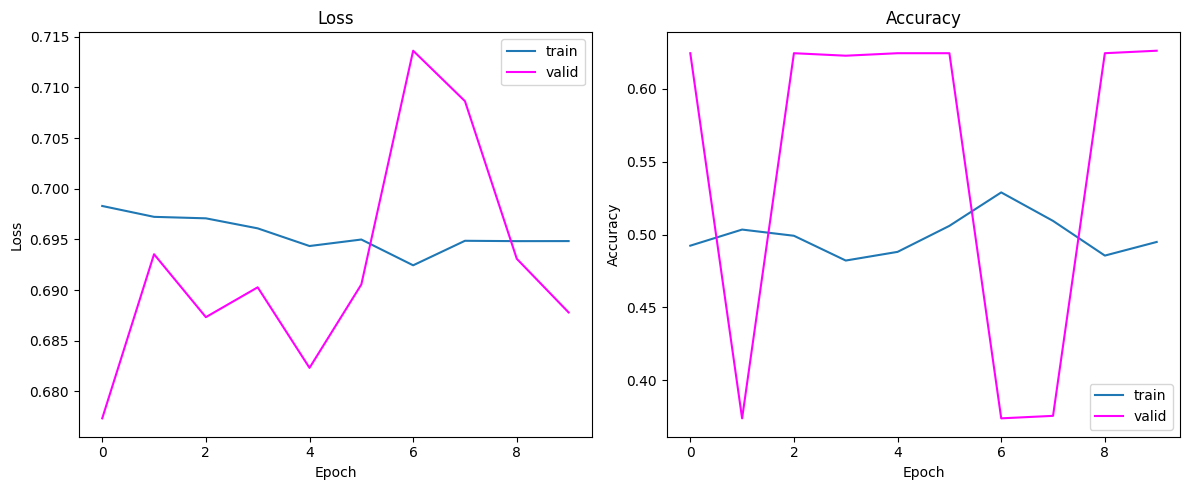

In [68]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

folder = './models_baseline'
os.makedirs(folder, exist_ok=True)

loss_train, loss_valid, acc_train, acc_val = training_loop_simple(
    num_epochs=10,
    model=baseline_model,
    loaders=loaders,
    loss_f=criterion,
   optimizer=optimizer,
    folder=folder
)

plot_training_curves(loss_train, loss_valid, acc_train, acc_val)

We can see from the training and validation plots that the model is not learning (neither training nor validation accuracies are increasing and the loss is not really decreasing either, rather fluctuating). It could be that the distribution of the validation set is favouring a higher accuracy here. While the Sigmoid activation function in the LeNet architecture was used for the MNIST dataset and yielded to decreasing loss for both the training and validation set (see Computer_vision_exercise_solutions.ipynb), colour images of size 256x256 might be too complex inputs, potentially leading to vanishing gradients, ultimately preventing the model from learning (Géron 2022: 333f.).

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=61504, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=1, bias=True)
)
cuda


100%|██████████| 25/25 [00:00<00:00, 55.01it/s]


Epoch 1
Training Loss: 0.4482, Training Acc: 0.7915
Validation Loss: 0.3601, Validation Acc: 0.8480
-------------------
Validation Loss Decreased (inf --> 0.3601) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 43.99it/s]


Epoch 2
Training Loss: 0.2812, Training Acc: 0.8919
Validation Loss: 0.2976, Validation Acc: 0.8903
-------------------
Validation Loss Decreased (0.3601 --> 0.2976) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 53.53it/s]


Epoch 3
Training Loss: 0.2002, Training Acc: 0.9221
Validation Loss: 0.2223, Validation Acc: 0.9120
-------------------
Validation Loss Decreased (0.2976 --> 0.2223) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 55.89it/s]


Epoch 4
Training Loss: 0.1543, Training Acc: 0.9434
Validation Loss: 0.2969, Validation Acc: 0.8863
-------------------


100%|██████████| 25/25 [00:00<00:00, 54.33it/s]


Epoch 5
Training Loss: 0.0824, Training Acc: 0.9715
Validation Loss: 0.2138, Validation Acc: 0.9223
-------------------
Validation Loss Decreased (0.2223 --> 0.2138) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 54.23it/s]


Epoch 6
Training Loss: 0.0468, Training Acc: 0.9830
Validation Loss: 0.2359, Validation Acc: 0.9240
-------------------


100%|██████████| 25/25 [00:00<00:00, 53.59it/s]


Epoch 7
Training Loss: 0.0488, Training Acc: 0.9834
Validation Loss: 0.2484, Validation Acc: 0.9263
-------------------


100%|██████████| 25/25 [00:00<00:00, 54.20it/s]


Epoch 8
Training Loss: 0.0519, Training Acc: 0.9813
Validation Loss: 0.2385, Validation Acc: 0.9400
-------------------


100%|██████████| 25/25 [00:00<00:00, 53.99it/s]


Epoch 9
Training Loss: 0.0117, Training Acc: 0.9962
Validation Loss: 0.2726, Validation Acc: 0.9320
-------------------


100%|██████████| 25/25 [00:00<00:00, 55.19it/s]


Epoch 10
Training Loss: 0.0027, Training Acc: 1.0000
Validation Loss: 0.2869, Validation Acc: 0.9223
-------------------
Average training time per epoch on cuda: 6.61 seconds
Total training time: 66.13 seconds


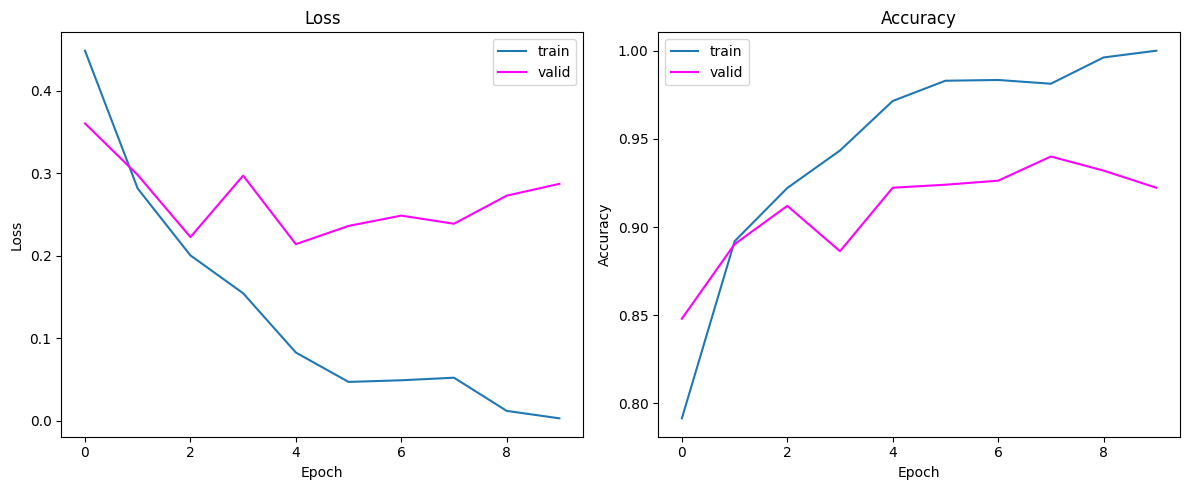

In [69]:
# baseline: LeNet, code modified after Computer_vision_exercise_solutions.ipynb and Géron 2022:463
import torch.nn as nn

baseline_model = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5, padding=2), nn.ReLU(), # colour image with 3 channels
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 62 * 62, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 1) # binary classification
)

print(baseline_model)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

folder = './models_baseline_relu'
os.makedirs(folder, exist_ok=True)

loss_train, loss_valid, acc_train, acc_val = training_loop_simple(
    num_epochs=10,
    model=baseline_model,
    loaders=loaders,
    loss_f=criterion,
   optimizer=optimizer,
    folder=folder
)

plot_training_curves(loss_train, loss_valid, acc_train, acc_val)

In the plots above we can see that only changing the activation function to ReLU yields in decreasing training loss and high training and validation accuracy. While the validation loss initially decreases, it fluctuates heavily and increases again, with validation accuracy only increasing slighly. This is a clear sign of overfitting, which could be mitigated by data augmentation and to add dropout or weight regularization (cf. Chollet 2021:104ff.)

### Finetune the pre-trained model

cuda


100%|██████████| 25/25 [00:01<00:00, 21.39it/s]


Epoch 1
Training Loss: 0.3084, Training Acc: 0.8757
Validation Loss: 0.1534, Validation Acc: 0.9600
-------------------
Validation Loss Decreased (inf --> 0.1534) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 21.09it/s]


Epoch 2
Training Loss: 0.1766, Training Acc: 0.9383
Validation Loss: 0.1093, Validation Acc: 0.9720
-------------------
Validation Loss Decreased (0.1534 --> 0.1093) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 21.31it/s]


Epoch 3
Training Loss: 0.1484, Training Acc: 0.9460
Validation Loss: 0.0828, Validation Acc: 0.9800
-------------------
Validation Loss Decreased (0.1093 --> 0.0828) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 17.67it/s]


Epoch 4
Training Loss: 0.1185, Training Acc: 0.9570
Validation Loss: 0.0722, Validation Acc: 0.9800
-------------------
Validation Loss Decreased (0.0828 --> 0.0722) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 17.30it/s]


Epoch 5
Training Loss: 0.1286, Training Acc: 0.9532
Validation Loss: 0.0611, Validation Acc: 0.9880
-------------------
Validation Loss Decreased (0.0722 --> 0.0611) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 19.55it/s]


Epoch 6
Training Loss: 0.1101, Training Acc: 0.9613
Validation Loss: 0.0595, Validation Acc: 0.9840
-------------------
Validation Loss Decreased (0.0611 --> 0.0595) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 20.95it/s]


Epoch 7
Training Loss: 0.1081, Training Acc: 0.9574
Validation Loss: 0.0672, Validation Acc: 0.9783
-------------------


100%|██████████| 25/25 [00:01<00:00, 21.42it/s]


Epoch 8
Training Loss: 0.1092, Training Acc: 0.9591
Validation Loss: 0.0492, Validation Acc: 0.9920
-------------------
Validation Loss Decreased (0.0595 --> 0.0492) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 21.33it/s]


Epoch 9
Training Loss: 0.0795, Training Acc: 0.9706
Validation Loss: 0.0492, Validation Acc: 0.9920
-------------------
Validation Loss Decreased (0.0492 --> 0.0492) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 20.82it/s]


Epoch 10
Training Loss: 0.0949, Training Acc: 0.9638
Validation Loss: 0.0572, Validation Acc: 0.9783
-------------------
Average training time per epoch on cuda: 13.19 seconds
Total training time: 131.85 seconds


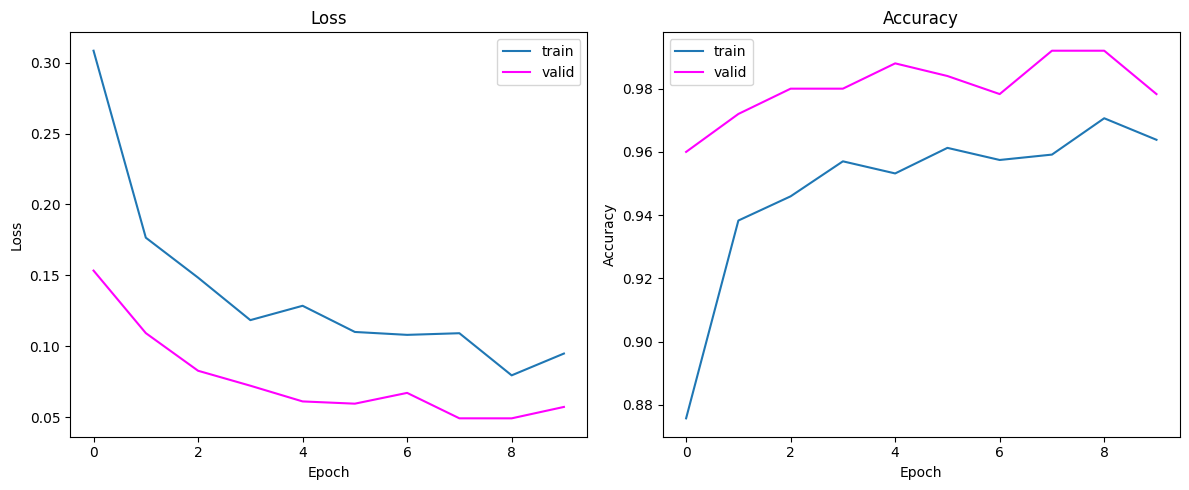

In [70]:
import numpy as np
import time
from tqdm import tqdm

criterion = nn.BCEWithLogitsLoss() # code for training loop modified after https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html and Computer_vision_exercise_solutions.ipynb
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

folder_resnet = './models_resnet'
os.makedirs(folder_resnet, exist_ok=True)

loss_train, loss_valid, acc_train, acc_val = training_loop_simple(
    num_epochs=10,
    model=resnet_model,
    loaders=loaders,
    loss_f=criterion,
    optimizer=optimizer,
    folder=folder_resnet
)
plot_training_curves(loss_train, loss_valid, acc_train, acc_val)

We can see from the plots above that both validation and training loss are decreasing and accuracy is increasing (though fluctuating after epoch 2). Generally, validation loss is lower than training loss and validation accuracy is higher than training accuracy, indicating that the model is generalizing well and no signs of overfitting can be detected. The training time however is doubled compared to training the LeNet architecture on our dataset from scratch.

## **Reporting the results**

The student should report the results. Identify which features are most influential in the model’s predictions, if applicable for the dataset and model used.

In [71]:
# Code modified after Computer_vision_exercise_solutions.ipynb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    correct = 0
    total = 0

    with torch.no_grad():
        for test_imgs, test_labels in test_loader:
            test_imgs, test_labels = test_imgs.to(device), test_labels.float().unsqueeze(1).to(device)
            output = model(test_imgs)
            probs = torch.sigmoid(output)
            preds = (probs > 0.5).float()
            correct += (preds == test_labels).sum().item()
            total += test_labels.size(0)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(test_labels.cpu().numpy().flatten())


    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds)
    print(f"Test accuracy: {accuracy:.3f}")
    print(f"Test F1 Score: {f1:.3f}")


def evaluate_confusion_matrix(model: nn.Module, test_loader) -> np.ndarray:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    lbl_pred = []
    lbl_test = []

    with torch.no_grad():
        for test_imgs, test_labels in test_loader:
            test_imgs, test_labels = test_imgs.to(device), test_labels.float().unsqueeze(1).to(device)
            output = model(test_imgs)
            probs = torch.sigmoid(output)
            preds = (probs > 0.5).float()

            lbl_pred.extend(preds.cpu().numpy().flatten())
            lbl_test.extend(test_labels.cpu().numpy().flatten())

    cm = confusion_matrix(lbl_test, lbl_pred)
    return cm

#### LeNet model with relu (and without data augmentation)

Test accuracy: 0.940
Test F1 Score: 0.949


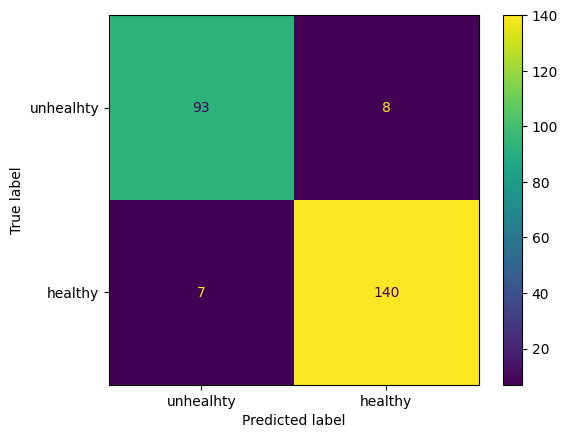

In [74]:
baseline_model.load_state_dict(torch.load('./models_baseline_relu/saved_model.pth'))
evaluate(baseline_model, loaders['test'])

cm = evaluate_confusion_matrix(baseline_model, loaders['test'])
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['unhealhty', 'healthy'])
cm_plot.plot()

Test accuracy: 0.988
Test F1 Score: 0.990


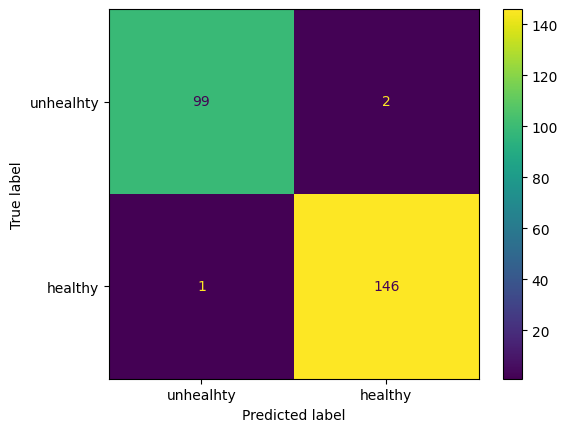

In [75]:
resnet_model.load_state_dict(torch.load('./models_resnet/saved_model.pth'))
evaluate(resnet_model, loaders['test'])
cm = evaluate_confusion_matrix(resnet_model, loaders['test'])
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['unhealhty', 'healthy'])
cm_plot.plot()

Comparing the performance of the baseline model (LeNet with ReLU activation function) and the pre-trained ResNet50 model, ...

### Does data augmentation improve model performance?

In [76]:
print("Size of training data before augmenting:", len(data_train))

# data augmentation for training set
data_train.oversample_minority_class_by_augmenting()

print("Size of training data after augmenting:", len(data_train))

# code modified from Computer_vision_exercise_solutions.ipynb
loaders = {
    'train' : torch.utils.data.DataLoader(data_train,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0),

    'validation'  : torch.utils.data.DataLoader(data_eval,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0),
    'test'  : torch.utils.data.DataLoader(data_test,
                                        batch_size=3,
                                        shuffle=False,
                                        num_workers=0),
}

print()
print(len(data_train))
print(len(data_eval))
print(len(data_test))

Size of training data before augmenting: 2350
Augmenting and oversampling dataset by 372 negatives examples.
Size of training data after augmenting: 2722

2722
247
248


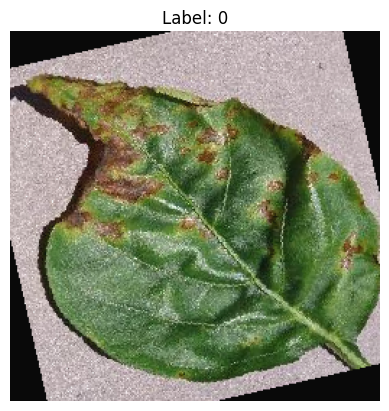

In [77]:
import torchvision.transforms.functional as TF

image, label = data_train[len(data_train)-1] # have a look at one augmented image (unhealthy bell pepper)
plt.imshow(TF.to_pil_image(image))
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

**Extra**: Any additional discussion and extra work relevant for solving the problem is welcome by the student and will contribute to a better grade.

In [ ]:
# either Optuna or mitigating overfitting in resnet

### References

Chollet, F. (2021). Deep learning with Python. simon and schuster.

Géron, A. (2022). Hands-on machine learning with Scikit-Learn, Keras, and
TensorFlow. " O'Reilly Media, Inc.".

He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (2002). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324.